# Implementation of: A Bandit Approach to Multiple Testing with False Discovery Control
By Kevin Jamieson, Lalit Jain

## User Inputs

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Number of arms
n = 100

# Variance
variance = 0.3

# Acquisition function
acq_func = "UCB1_Normal_delta"

# Sample Budget
B =  2000 #600

# Sampling method
#sample_method = "Uniform"
sample_method = "Adaptive"

# Threshold for prediction
mean_threshold = 0.5

# False Discovery Rate
delta = 0.15
d_dash = False

# TPR
TPR = True

# Coefficient in front of confidence function
c = 4

# Initial sampling
initial_loop = math.ceil(8*np.log(delta**(-1/4)))

# Visualise plots
visualise = False

# Plot out every 'how  many' iterations
plot_n = 500

## Set up Code

In [20]:
# CLASS: BANDIT to store information about each bandit in the game
class Bandit:

    def __init__(self,n,bandit_number):

            self.true_mean = (bandit_number)/n
            self.true_variance = variance

            self.sample_mean = 0
            self.bandit_trial = 0
            
            self.q = 0


    def Sample_Bandit(self):
        
        # Update number of trials of bandit
        self.bandit_trial += 1

        # Pull arm and return reward
        reward = np.random.normal(self.true_mean, self.true_variance,1)

        # Update bandit sample mean
        self.sample_mean = self.sample_mean + (reward - self.sample_mean)/self.bandit_trial
        
        # Updated sum of squared rewards
        self.q = self.q + reward**2

        return reward


# CLASS: GAME to store results of game (made up of bandits)
class Game:

    def __init__(self,n,acq_func,delta,TPR):
        
        self.n = n
        self.total_trials = 0
        self.St = {}
        self.FDR = list()
        self.TPR = list()
        
        if TPR == True:
            e_t = 1
            v_t = 1
            
            
        self.H0 = list()
        self.H1 = list()
        self.bandit_dictionary = {}

        # Create each bandit 
        for i in range(self.n):
            self.bandit_dictionary[str(i+1)] = {}
            self.bandit_dictionary[str(i+1)] = Bandit(self.n,i+1)
            
            if self.bandit_dictionary[str(i+1)].true_mean > mean_threshold:
                self.H1.append(i+1)
            else:
                self.H0.append(i+1)
        
        # Conduct and initial sample from each bandit
        
        for il in range(initial_loop):
            for i in range(self.n):
                self.bandit_dictionary[str(i+1)].Sample_Bandit()
                self.total_trials += 1
            self.FDR.append(Game.FDR_function(self))
            self.TPR.append(Game.TPR_function(self))
            
        #Plot distribution
        
        #print('trial' + str(self.total_trials))
        y = np.zeros([1,self.n]).reshape(-1,)
        no_pulls = np.zeros([1,self.n]).reshape(-1,)
        for i in range(self.n):
            y[i] = self.bandit_dictionary[str(i+1)].sample_mean
            no_pulls[i] = self.bandit_dictionary[str(i+1)].bandit_trial 

        print('trial: ' + str(self.total_trials))
        print('Number of arm pulls: ' + str(no_pulls))
        if visualise == True:
            plt = Game.Visualise(self,y,delta,mean_threshold,acq_func)
            plt.show()

        # Sample according to sampling method
        if sample_method == "Uniform":
            times = int(B/self.n)
            for j in range(times):
                for i in range(self.n):
                    self.bandit_dictionary[str(i+1)].Sample_Bandit()
                    self.total_trials += 1
        else:
            while self.total_trials < B:
                
                #Select next arm to sample
                acq_value = -1000
                arm_next = 1
                
                for i in range(self.n):
                    if ((i+1) not in self.St):

                        bandit_info = self.bandit_dictionary[str(i+1)]
                        
                        I =  bandit_info.sample_mean + Game.Confidence_Interval(self,bandit_info,delta/e_t,c,acq_func)
                        if I > acq_value:
                            acq_value = I
                            arm_next = i+1
                
                # Pull the selected arm
                self.bandit_dictionary[str(arm_next)].Sample_Bandit()
                self.total_trials += 1
                
                # Update St
                self = Game.Update_St(self,delta,acq_func)
                
                self.FDR.append(Game.FDR_function(self))
                self.TPR.append(Game.TPR_function(self))
                
                #Plot distribution
                if self.total_trials % plot_n == 0:
                    print('trial: ' + str(self.total_trials))
                    print(self.St)
                    y = np.zeros([1,self.n]).reshape(-1,)
                    no_pulls = np.zeros([1,self.n]).reshape(-1,)
                    for i in range(self.n):
                        y[i] = self.bandit_dictionary[str(i+1)].sample_mean
                        no_pulls[i] = self.bandit_dictionary[str(i+1)].bandit_trial 

                    print('Number of arm pulls: ' + str(no_pulls))
                    if visualise == True:
                        plt = Game.Visualise(self,y,delta,mean_threshold,acq_func)
                        plt.show()
                    
    
    def Visualise(self,mean,delta,mu_threshold,acq_func):
    
        plt.style.use('seaborn-whitegrid')
        x = np.linspace(1,self.n,self.n)
        color = ['g','r','b','k','y','m']
        ranges = np.linspace(n,0,n)
        
        if d_dash == True:
            delta_dash = delta/(6.4*np.log(36/delta))
        else:
            delta_dash = delta
        
        dy = np.zeros([1,self.n]).reshape(-1,)
        for k in ranges:
            k = int(k)
            for i in range(self.n):
                dy[i] = Game.Confidence_Interval(self,self.bandit_dictionary[str(i+1)],delta_dash*(k+1)/self.n,c,acq_func)
            
            #plt.errorbar(x, mean, yerr=dy, fmt='o', color='black',ecolor=color[k], elinewidth=20-3*k, capsize=20-3*k)
            plt.errorbar(x, mean, yerr=dy, fmt='o', color='black',ecolor=color[k], elinewidth=3*k+1, capsize=3*k+1)

        plt.axhline(mu_threshold)

        return plt
    
    def FDR_function(self):
        
        numerator = 0
        for i in self.St:
            if i in self.H0:
                numerator += 1
        
        if len(self.St) != 0:
            FDR = numerator/len(self.St)
        else:
            FDR = 0
            
        return FDR

    def TPR_function(self):
        
        numerator = 0
        for i in self.St:
            if i in self.H1:
                numerator += 1
        
        if len(self.St) != 0:
            TPR = numerator/len(self.H1)
        else:
            TPR = 0
            
        return TPR
    
    def Confidence_Interval(self,bandit_info,d,c,acq_func):
        
        t = bandit_info.bandit_trial
        mean = bandit_info.sample_mean
        
        if acq_func == "UCB1":
            Confidence_value = np.sqrt((c*np.log(np.log2(2*t)/d))/(t))
            
        elif acq_func == "d-PAC":
            e = np.exp(1)
            val = 2*np.log(1/d) + 6*np.log(np.log(1/d)) + 3*np.log(np.log(e*t/2))
            Confidence_value = np.sqrt(val/t)
            
        elif acq_func == "UCB1_Normal":
            
            q = bandit_info.q
            term1 = (np.sum(q) - t*mean**2)/(t-1)
            term2 = np.log(self.total_trials - 1)/t
            Confidence_value = np.sqrt(16*term1*term2)
            
        elif acq_func == "UCB1_Normal_delta":
            
            q = bandit_info.q
            term1 = (np.sum(q) - t*mean**2)/(t-1)
            #term2 = np.log(d**(-1/4) - 1)/t
            term2 = np.log(d**(-1/4))/t
            Confidence_value = np.sqrt(16*term1*term2)

        elif acq_func == "UCB1_derived":
            Confidence_value = np.sqrt((-1*np.log(d))/(2*t))
        
        return Confidence_value
    
    def Update_St(self, delta,acq_func):
        
        # Apply Benjamini-Hochberg
        if d_dash == True:
            delta_dash = delta/(6.4*np.log(36/delta))
        else:
            delta_dash = delta
 
        # Discover St set
        K_LENGTH = 0
        for k in range(self.n):
            
            k_list = list()
            
            for i in range(self.n):
            
                bandit_info = self.bandit_dictionary[str(i+1)]
 
                confidence = Game.Confidence_Interval(self,bandit_info,delta_dash*(k+1)/self.n,c,acq_func)
                I = bandit_info.sample_mean - confidence
                
                    
                if (I >= mean_threshold):
                    k_list.append((i+1))

            len_k = len(k_list)
            if (len_k > K_LENGTH) and (len_k >= (k+1)):
                self.St = k_list
                #print(k)
            
        return self

## Run Experiment

trial: 600
Number of arm pulls: [6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6.]
trial: 1000
[67, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
Number of arm pulls: [ 6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  7.  8.  6.  6.  6.  6.  6.  6.  6.  8.  6. 11.  9.  6.  6.  6.  7.  6.
  6.  6.  6.  8.  6.  6.  6.  6. 15.  6.  6. 21.  6.  6. 12.  6.  7.  7.
  7. 14.  6.  8. 16. 21. 25.  7. 24. 33.  7.  6. 26. 14. 36. 28. 20. 11.
 37.  6. 14. 22. 11. 18.  6. 14. 10.  9. 18.  7. 10.  6.  9. 12.  6.  8.
  6. 10.  6.  6. 12. 15.  8. 16. 10.  7.]
trial: 1500
[61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,

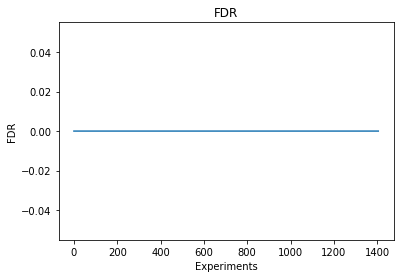

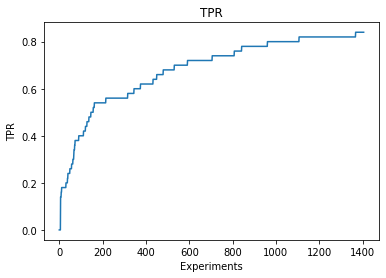

In [21]:
acq_func = "UCB1_Normal_delta"

# False Discovery Rate
delta = 0.05
d_dash = False

G = Game(n,acq_func,delta,TPR)

print("Arm's that are above threshold:")
print(G.St)

plt.plot(G.FDR)
plt.title('FDR')
plt.xlabel('Experiments')
plt.ylabel('FDR')
plt.show()
    
plt.plot(G.TPR)
plt.title('TPR')
plt.xlabel('Experiments')
plt.ylabel('TPR')
plt.show()

trial: 600
Number of arm pulls: [6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6.]
trial: 1000
[72, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
Number of arm pulls: [ 6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6. 10.  6.  6.  6.  6.  9.  6.  6.  7.  6.
  6.  6.  8. 12.  7.  8.  7.  6. 11. 18.  6. 10. 24. 12.  7. 16. 16.  6.
  6. 15. 15. 34.  6. 13. 10. 18. 27.  6. 25. 27. 23. 18. 29. 11. 16. 24.
  9. 26. 29.  6. 12. 13. 11. 17. 14. 22.]
trial: 1500
[67, 72, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
Number

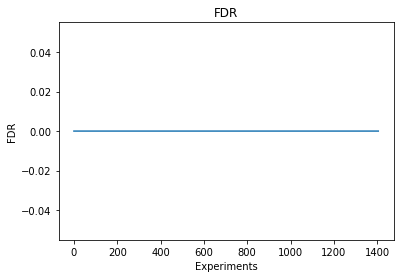

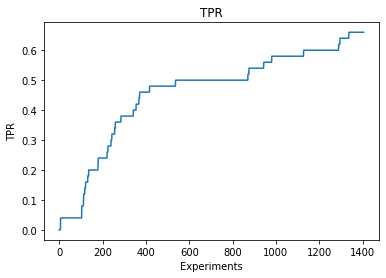

In [22]:
acq_func = "UCB1_Normal_delta"

# False Discovery Rate
delta = 0.05
d_dash = True

G = Game(n,acq_func,delta,TPR)

print("Arm's that are above threshold:")
print(G.St)

plt.plot(G.FDR)
plt.title('FDR')
plt.xlabel('Experiments')
plt.ylabel('FDR')
plt.show()
    
plt.plot(G.TPR)
plt.title('TPR')
plt.xlabel('Experiments')
plt.ylabel('TPR')
plt.show()

trial: 400
Number of arm pulls: [4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4.]
trial: 500
[68, 69, 71, 81, 82, 84, 87, 88, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
Number of arm pulls: [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  5.
  4.  4.  4.  5.  4.  4.  4.  4.  4.  6.  4.  8.  4.  6.  5.  4.  4.  7.
  4.  4.  8.  4.  4.  5.  5.  5.  8.  4.  9.  5.  5.  4.  4.  5.  4.  5.
  5.  4.  7.  4.  7.  4.  8. 10.  7.  4. 10.  8.  4.  4.  4. 19.  5.  4.
  5.  7.  4.  4.  9.  5.  8. 10.  4.  4.]
trial: 1000
[59, 65, 66, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

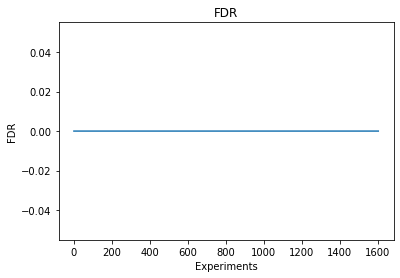

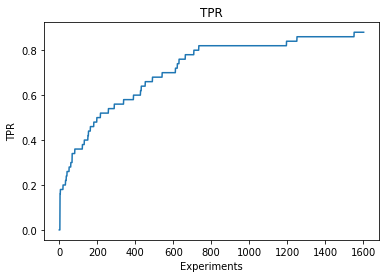

In [26]:
acq_func = "UCB1_Normal_delta"

# False Discovery Rate
delta = 0.15
d_dash = False

G = Game(n,acq_func,delta,TPR)

print("Arm's that are above threshold:")
print(G.St)

plt.plot(G.FDR)
plt.title('FDR')
plt.xlabel('Experiments')
plt.ylabel('FDR')
plt.show()
    
plt.plot(G.TPR)
plt.title('TPR')
plt.xlabel('Experiments')
plt.ylabel('TPR')
plt.show()

trial: 400
Number of arm pulls: [4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4.]
trial: 500
[33, 82, 86, 90, 96, 98]
Number of arm pulls: [ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  6.  4.  4.  4.  4.  4.
  4.  4.  6.  4.  4.  4.  4.  5.  4.  4.  4.  4.  4.  4.  4.  4.  4.  6.
  4.  4.  4.  5.  4.  4.  4.  5.  6. 17.  7.  4.  5.  4.  4.  8. 14. 12.
  4.  4.  8. 13. 17. 16.  6.  9.  9.  4.]
trial: 1000
[33, 69, 72, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
Number of arm pulls: [ 4.  4.  4.  4.  4.  6.  4.  4.  4.  4.  4.  4.  4

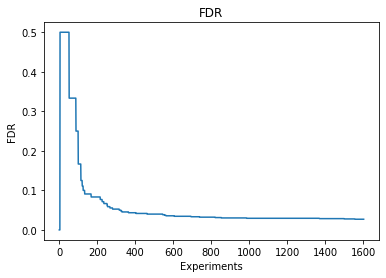

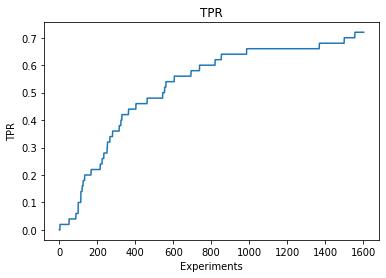

In [27]:
acq_func = "UCB1_Normal_delta"

# False Discovery Rate
delta = 0.15
d_dash = True

G = Game(n,acq_func,delta,TPR)

print("Arm's that are above threshold:")
print(G.St)

plt.plot(G.FDR)
plt.title('FDR')
plt.xlabel('Experiments')
plt.ylabel('FDR')
plt.show()
    
plt.plot(G.TPR)
plt.title('TPR')
plt.xlabel('Experiments')
plt.ylabel('TPR')
plt.show()